## 基于密度的算法DBSCAN

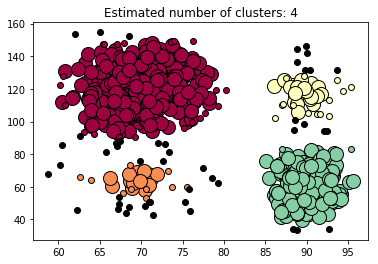

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# A校生
mu1, sigma1 = 70, 4.2
x1 = mu1 + sigma1 * np.random.randn(400)

iq_mu1,iq_sigma1 = 120,15 # 学习时间长
iq_mu2,iq_sigma2 = 60,10  # 学习时间短

tmp1 = iq_mu1 + iq_sigma1 * np.random.randn(350)
tmp2 = iq_mu2 + iq_sigma2 * np.random.randn(50)

y1 = np.append(tmp1,tmp2)

# B校生
mu2,sigma2 = 90,2.1
x2 = mu2 + sigma2 * np.random.randn(300)

tmp3 = iq_mu1 + iq_sigma1 * np.random.randn(50)
tmp4 = iq_mu2 + iq_sigma2 * np.random.randn(250)

y2 = np.append(tmp3,tmp4)

# 水平组合
dataSet1 = np.column_stack((x1,y1))
dataSet2 = np.column_stack((x2,y2))

dataSet = np.vstack((dataSet1,dataSet2))

# 这里我们分别取ϵ=5和MinPts =10，利用sklearn中的DBSCAN算法：

# DBSCAN算法
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=5, min_samples=10).fit(dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# 标签中的簇数，如果存在噪声，则忽略噪声。
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


import matplotlib.pyplot as plt

# 去除黑色用噪音代替
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # 用于噪音的黑色
        col = 'k'

    class_member_mask = (labels == k)

    xy = dataSet[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = dataSet[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## 孤立森林算法

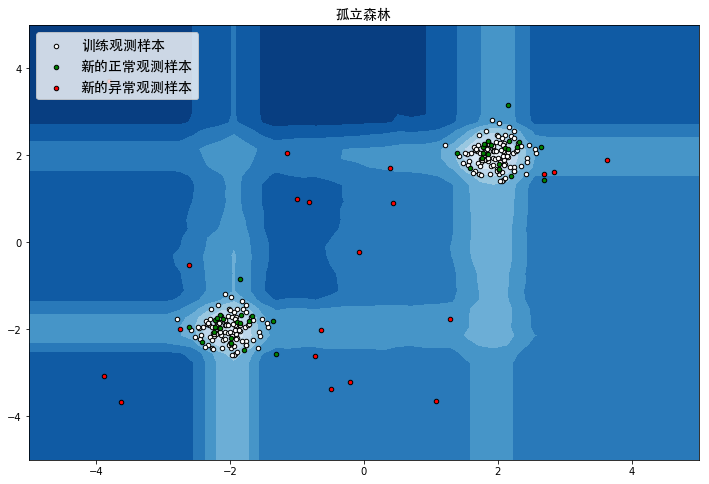

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# 生成训练数据
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# 生成一些常规的新的观察结果
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# 生成一些异常的新的观察结果
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# 拟合模型
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# 将直线、样本和最近向量绘制到平面上
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/System/Library/Fonts/STHeiti Medium.ttc', size=14)
plt.title("孤立森林", fontproperties=font)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["训练观测样本",
            "新的正常观测样本", "新的异常观测样本"],
           loc="upper left", prop=font)
plt.show()

## 几种算法比较

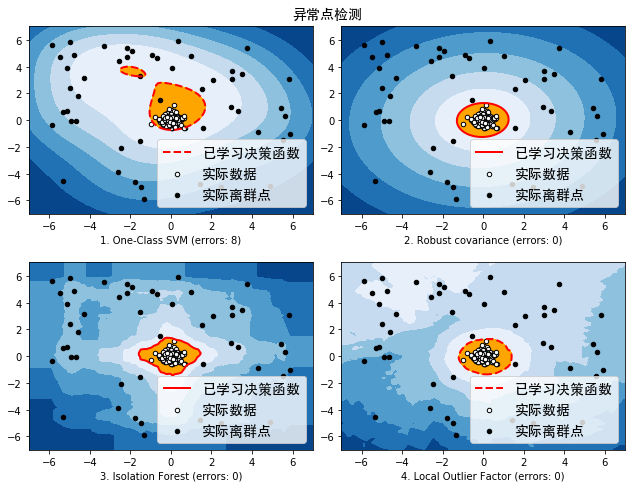

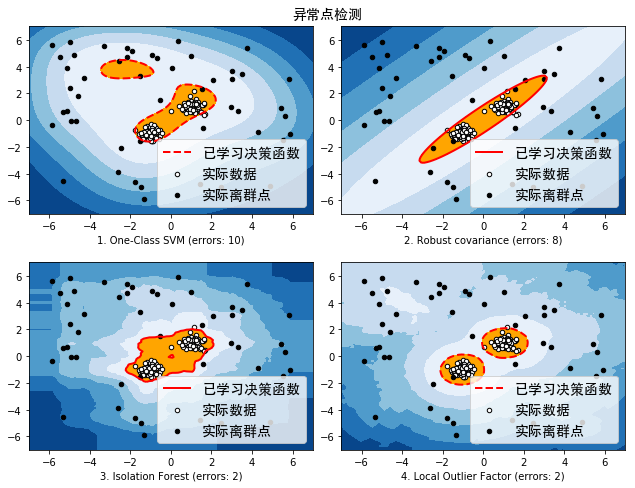

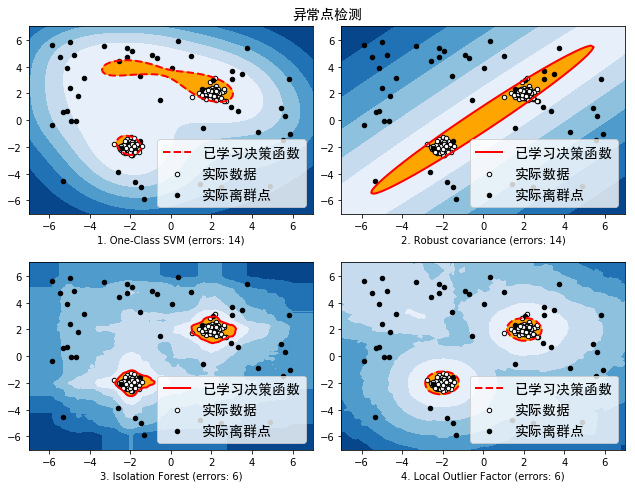

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

rng = np.random.RandomState(42)

# 设置
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# 定义两个异常值检测工具进行比较
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# 给定条件下给定分类器的比较
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# 用不同的簇分离法拟合问题
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # 生成数据
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # 添加异常点
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # 拟合模型
    plt.figure(figsize=(9, 7))
    from matplotlib.font_manager import FontProperties
    font = FontProperties(fname='/System/Library/Fonts/STHeiti Medium.ttc', size=14)
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # 拟合数据和标记离群值
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # 绘制水平线和点
        if clf_name == "Local Outlier Factor":
            # LOF私有函数decision_function
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['已学习决策函数', '实际数据', '实际离群点'],
            prop=font,
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("异常点检测", fontproperties=font)

plt.show()

## 时间序列预测

In [15]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [16]:
df = pd.read_csv('../datasets/taobao_ip.csv')
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,排名,每百万网民访问该站的人数,每百万受访网页该站网页数,人均浏览页面数,y
0,2009-01-01,43,12900,3239,17.8,7224000
1,2009-01-02,41,12700,4030,22.7,7112000
2,2009-01-03,41,12800,3811,20.8,7168000
3,2009-01-04,39,13500,4012,20.9,7560000
4,2009-01-05,37,13700,3957,20.5,7672000


In [17]:
m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3312,2017-12-27
3313,2017-12-28
3314,2017-12-29
3315,2017-12-30
3316,2017-12-31


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3312,2017-12-27,2.190691e+07,1.678109e+07,2.643338e+07
3313,2017-12-28,2.176952e+07,1.645487e+07,2.687152e+07
3314,2017-12-29,2.153504e+07,1.624168e+07,2.627145e+07
3315,2017-12-30,2.201091e+07,1.712914e+07,2.683469e+07
3316,2017-12-31,2.209634e+07,1.688618e+07,2.698460e+07


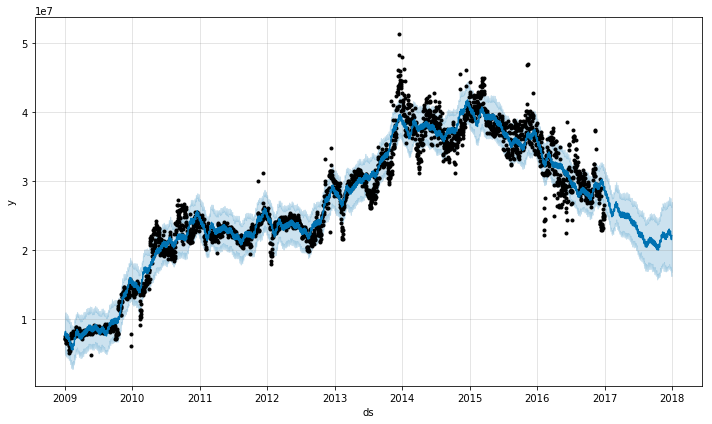

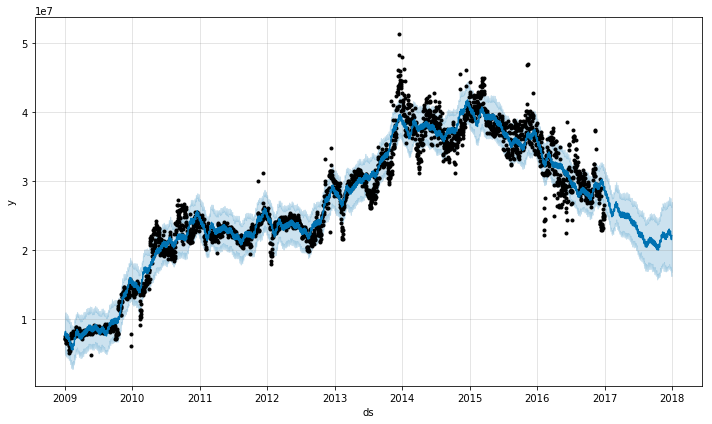

In [20]:
m.plot(forecast)

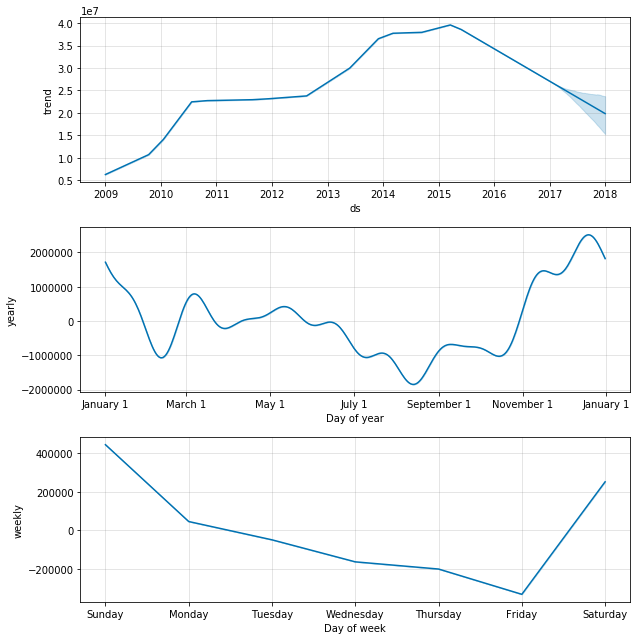

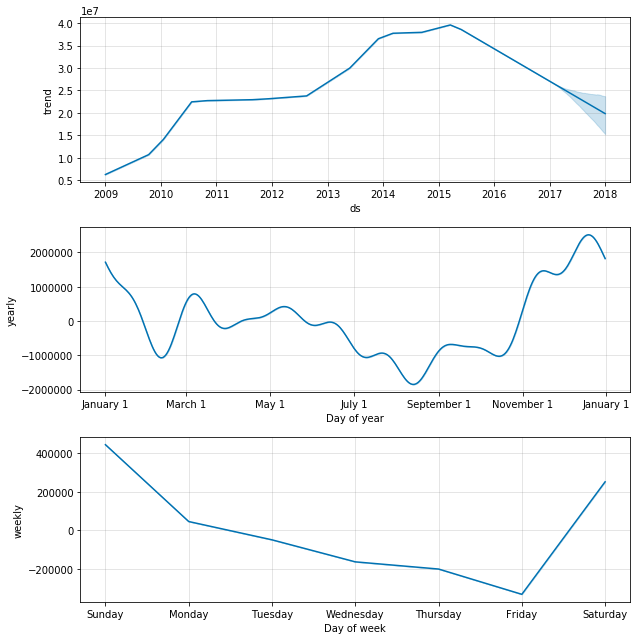

In [21]:
m.plot_components(forecast)

In [23]:
df.head()

,ds,排名,每百万网民访问该站的人数,每百万受访网页该站网页数,人均浏览页面数,y
0,2009-01-01,43,12900,3239,17.8,7224000
1,2009-01-02,41,12700,4030,22.7,7112000
2,2009-01-03,41,12800,3811,20.8,7168000
3,2009-01-04,39,13500,4012,20.9,7560000
4,2009-01-05,37,13700,3957,20.5,7672000


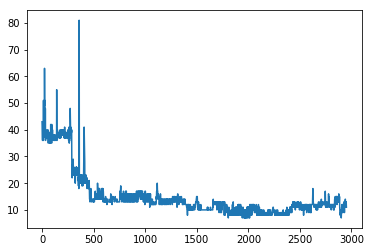

In [25]:
df['排名'].plot()

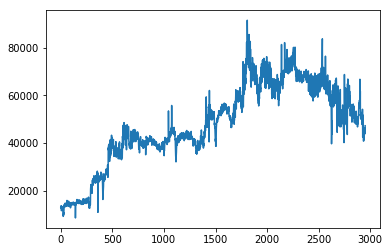

In [26]:
df['每百万网民访问该站的人数'].plot()

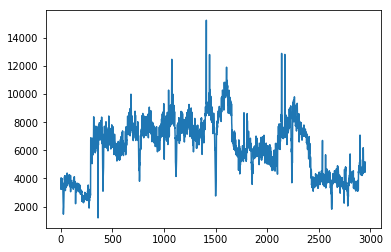

In [27]:
df['每百万受访网页该站网页数'].plot()

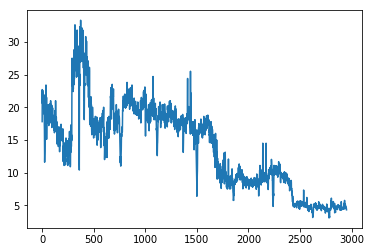

In [28]:
df['人均浏览页面数'].plot()

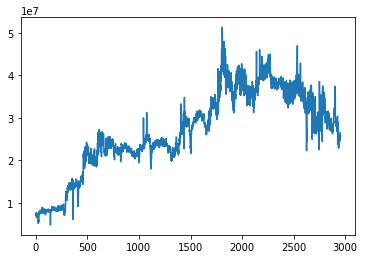

In [29]:
df['y'].plot()